In [14]:
import numpy as np
import sys
from scipy.stats import entropy
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager 
from matplotlib.pyplot import gca
import matplotlib
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import qutip as qt
from qutip_qip.operations import cnot, hadamard_transform
import scipy as sc
from time import time 
import seaborn as sns

path_main = '/Users/stepanvinckevich/Desktop/IMPORTANT NOW/QIS QRL/CODE/qRC/'
path_EVAL = path_main + 'EVALUATION/ENTANGLEMENT_ANALYSIS/'
path_PRODUCT =  path_EVAL + 'PRODUCTION/'
sys.path.append(path_main)




In [31]:
# Number of qubits in reservoirs A and B
n_qubitsA = 2
k_power_A = 0

n_qubitsB = 3
k_power_B = 0

# Evolution timestep
timestep = 0.1
# Trace preserving tolerance
tp_tol = 1e-5

n_qubits_total = n_qubitsA + n_qubitsB

# Hamiltonian of A
if k_power_A != 0:
    hamiltonianA = qt.Qobj(np.load(f'/content/gdrive/My Drive/QRC/hamiltonians/hamiltonian{n_qubitsA}_{k_power_A}.npy'), dims=[[2]*n_qubitsA, [2]*n_qubitsA])
else:
    hamiltonianA = qt.Qobj(np.load(path_main + f'/hamiltonians/hamiltonian{n_qubitsA}.npy'), dims=[[2]*n_qubitsA, [2]*n_qubitsA])
identityA = qt.identity(2**n_qubitsA)
identityA.dims = [[2]*n_qubitsA, [2]*n_qubitsA]

# Hamiltonian of B
if k_power_B != 0:
    hamiltonianB = qt.Qobj(np.load(f'/content/gdrive/My Drive/QRC/hamiltonians/hamiltonian{n_qubitsB}_{k_power_B}.npy'), dims=[[2]*n_qubitsB, [2]*n_qubitsB])
else:
    hamiltonianB = qt.Qobj(np.load(path_main + f'/hamiltonians/hamiltonian{n_qubitsB}.npy'), dims=[[2]*n_qubitsB, [2]*n_qubitsB])
identityB = qt.identity(2**n_qubitsB)
identityB.dims = [[2]*n_qubitsB, [2]*n_qubitsB]

# Total hamiltonian
hamiltonian = qt.tensor(hamiltonianA, identityB) + qt.tensor(identityA, hamiltonianB)
# hamiltonian = hamiltonianA


# Evolution step propagator
propagator = qt.propagator(hamiltonian, timestep)
propagator_dag = propagator.dag().full()
propagator = propagator.full()

# Evolution of entanglement sites a and b (now taken as identity)
prop_a = np.eye(2)
prop_b = np.eye(2)

#################################################


P0 = qt.basis(2,0) 
P1 = qt.basis(2,1)


P00 = qt.tensor(P0,P0)
P01 = qt.tensor(P0,P1)
P10 = qt.tensor(P1,P0)
P11 = qt.tensor(P1,P1)


In [16]:


# DEPOLARIZATION CHANNEL
def get_depol_ops(site):
    sx = np.kron(np.eye(2**site), np.kron(np.array([[0., 1.], [1., 0.]]), np.eye(2**(n_qubits_total - site - 1))))
    sy = np.kron(np.eye(2**site), np.kron(np.array([[0., -1j], [1j, 0.]]), np.eye(2**(n_qubits_total - site - 1))))
    sz = np.kron(np.eye(2**site), np.kron(np.array([[1., 0.], [0., -1.]]), np.eye(2**(n_qubits_total - site - 1))))
    return sx, sy, sz

def ptrace(mtx, hold):
    """Performs partial trace of state with only one site #hold remains"""
    indexes = list(range(2*n_qubits_total))
    axis_order = [indexes.pop(hold), indexes.pop(hold + n_qubits_total - 1)]
    axis_order = indexes + axis_order
    mtx = np.transpose(np.reshape(mtx, [2]*2*n_qubits_total), axis_order)
    return np.trace(np.reshape(mtx, (2**(n_qubits_total-1), 2**(n_qubits_total-1), 2, 2)))

def evolution_step(state):
    """Simple application of evolution step propagator"""
    state = propagator @ state @ propagator_dag
    # assert np.abs(np.trace(state) - 1.) < tp_tol, f"Trace is not preserved.{np.trace(state)}"
    return state / np.trace(state)

def nonselctive_meas_ch(state,b,c):
    psi00 = b * P00 + np.sqrt(1 - b**2) * P11 
    B00 = psi00 * psi00.dag()
    B00 = B00.full()

    psi11 = -b * P11 + np.sqrt(1 - b**2) * P00 
    B11 = psi11 * psi11.dag()
    B11 = B11.full()

    psi01 = c * P01 + np.sqrt(1 - c**2) * P10 
    B01 = psi01 * psi01.dag()
    B01 = B01.full()

    psi10 = -c * P10 + np.sqrt(1 - c**2) * P01 
    B10 = psi10 * psi10.dag()
    B10 = B10.full()

    PB00_dag = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(B00.T.conj(), np.eye(2**(n_qubitsB - 1))))
    PB00 = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(B00, np.eye(2**(n_qubitsB - 1))))

    PB11_dag = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(B11.T.conj(), np.eye(2**(n_qubitsB - 1))))
    PB11 = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(B11, np.eye(2**(n_qubitsB - 1))))

    PB01_dag = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(B01.T.conj(), np.eye(2**(n_qubitsB - 1))))
    PB01 = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(B01, np.eye(2**(n_qubitsB - 1))))

    PB10_dag = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(B10.T.conj(), np.eye(2**(n_qubitsB - 1))))
    PB10 = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(B10, np.eye(2**(n_qubitsB - 1))))
    
    state = PB00 @ state @ PB00_dag + PB11 @ state @ PB11_dag + PB10 @ state @ PB10_dag + PB01 @ state @ PB01_dag
    
    return state

def entangled_channel_step(state, p, b,с):
    """Application of entanglement channel with and depolarization channel with probability of depolarization 'p'"""
    state = nonselctive_meas_ch(state,b,с)
    if p != 0:
        for site in [0, 1, 4, 5]:
            state = (1 - p) * state + p/3 * sum([depol_ops[site][i] @ state @ depol_ops[site][i] for i in range(3)])
    return state / np.trace(state)

tracing_krauss0 = np.concatenate([np.eye(2**(n_qubits_total - 1)), np.zeros((2**(n_qubits_total - 1), 2**(n_qubits_total - 1)))], axis=1)
tracing_krauss1 = np.concatenate([np.zeros((2**(n_qubits_total - 1), 2**(n_qubits_total - 1))), np.eye(2**(n_qubits_total - 1))], axis=1)

def get_encoding_krauss(inp):
    tensor_product_krauss = np.eye(2**(n_qubits_total - 1)).ravel()
    tensor_product_krauss = np.stack([tensor_product_krauss * np.sqrt(inp), tensor_product_krauss * np.sqrt(1. - inp)]).reshape(2**(n_qubits_total), 2**(n_qubits_total-1))
    return tensor_product_krauss


def encoding_step(state, inp):
    """Encoding of inp to reservoir site #0"""
    # Partial trace. #0 site is traced out
#     axis_order = [0, n_qubits_total] + list(range(1, n_qubits_total)) + list(
#         range(n_qubits_total + 1, 2*n_qubits_total))
#     traced_dm = np.trace(np.reshape(
#         np.transpose(np.reshape(state, [2]*2*n_qubits_total), axis_order),
#         (2, 2, 2**(n_qubits_total-1), 2**(n_qubits_total-1))
#     ))
#     # Encoding
#     encoding_node_state = np.array([[np.sqrt(inp), np.sqrt(1. - inp)]])
#     return np.kron(encoding_node_state.T @ encoding_node_state, traced_dm)
    enc_krauss = get_encoding_krauss(inp)
    state = tracing_krauss0 @ state @ tracing_krauss0.T + tracing_krauss1 @ state @ tracing_krauss1.T
    state = enc_krauss @ state @ enc_krauss.T
    return state



In [17]:
def evaluate_evolution(init_state,depolarization_prob, b,c, N_steps, signal):
    # Initialization
    state = init_state
    for i in range(N_steps):
        state = encoding_step(state, signal[i])
        state = evolution_step(state)
        state = entangled_channel_step(state, depolarization_prob,b,c) 
        state = evolution_step(state)
    return  state

In [23]:

#Initial density matrix
init_state = qt.tensor(*[qt.rand_ket(2) for _ in range(n_qubits_total)])
#init_state = qt.tensor(*[qt.rand_dm(2) for _ in range(n_qubits_total)])
init_state = init_state * init_state.dag()
init_state = init_state.full()

# # inintial signal sample
# #signal = np.load(path_main + '/data/complex_signal_9_9.npy')
signal = [np.random.choice(2) for _ in range(2200)]
# np.save(path_EVAL + 'signal_rand_seed20', signal)
np.save(path_EVAL + 'init_state_rand_dm_seed20', init_state)

In [24]:
#signal = np.load(path_EVAL + 'signal_rand_seed20' + '.npy')
#init_state =  np.load(path_EVAL + 'init_state_rand_dm_seed20' + '.npy')

In [25]:
np.trace(init_state @ init_state)

(0.9999999999999999+0j)

In [26]:
def negativity_purity(N_points, init_state):
    negativity_arr = np.zeros((N_points,N_points))
    purity_arr = np.zeros((N_points,N_points))
    b, c = np.meshgrid(np.linspace(0,1, N_points), np.linspace(0,1, N_points))
    for i in range(len(b)):
        for j in range(len(c)):
            res_state = evaluate_evolution(init_state,0, b[0,:][i],c[:,0][j], 2000, signal)
            purity_arr[i][j] = np.real(np.trace(res_state @ res_state))
            # Converting to Qutip format. Bipartite separation dim H_RA = 4; dim H_RB = 8
            qt_state = qt.Qobj(res_state, dims = [[4,8],[4,8]])
            qt_state_Tb = qt.partial_transpose(qt_state,[0,1])
            neg = (qt_state_Tb.norm(norm = 'tr')- 1)/2
            if neg < 10**-9:
                neg = 0
            negativity_arr[i][j] = neg
    return b,c,negativity_arr, purity_arr


In [27]:
N_points = 50
t1 = time()
b,c, negativity_arr, purity_arr = negativity_purity(50, init_state)
t2 = time()
print('Eval.time {}'.format(t2-t1))

Eval.time 11134.421174049377


In [28]:
np.save(path_EVAL + 'purity_' + str(N_points), purity_arr)
np.save(path_EVAL + 'negativity_' + str(N_points), purity_arr)

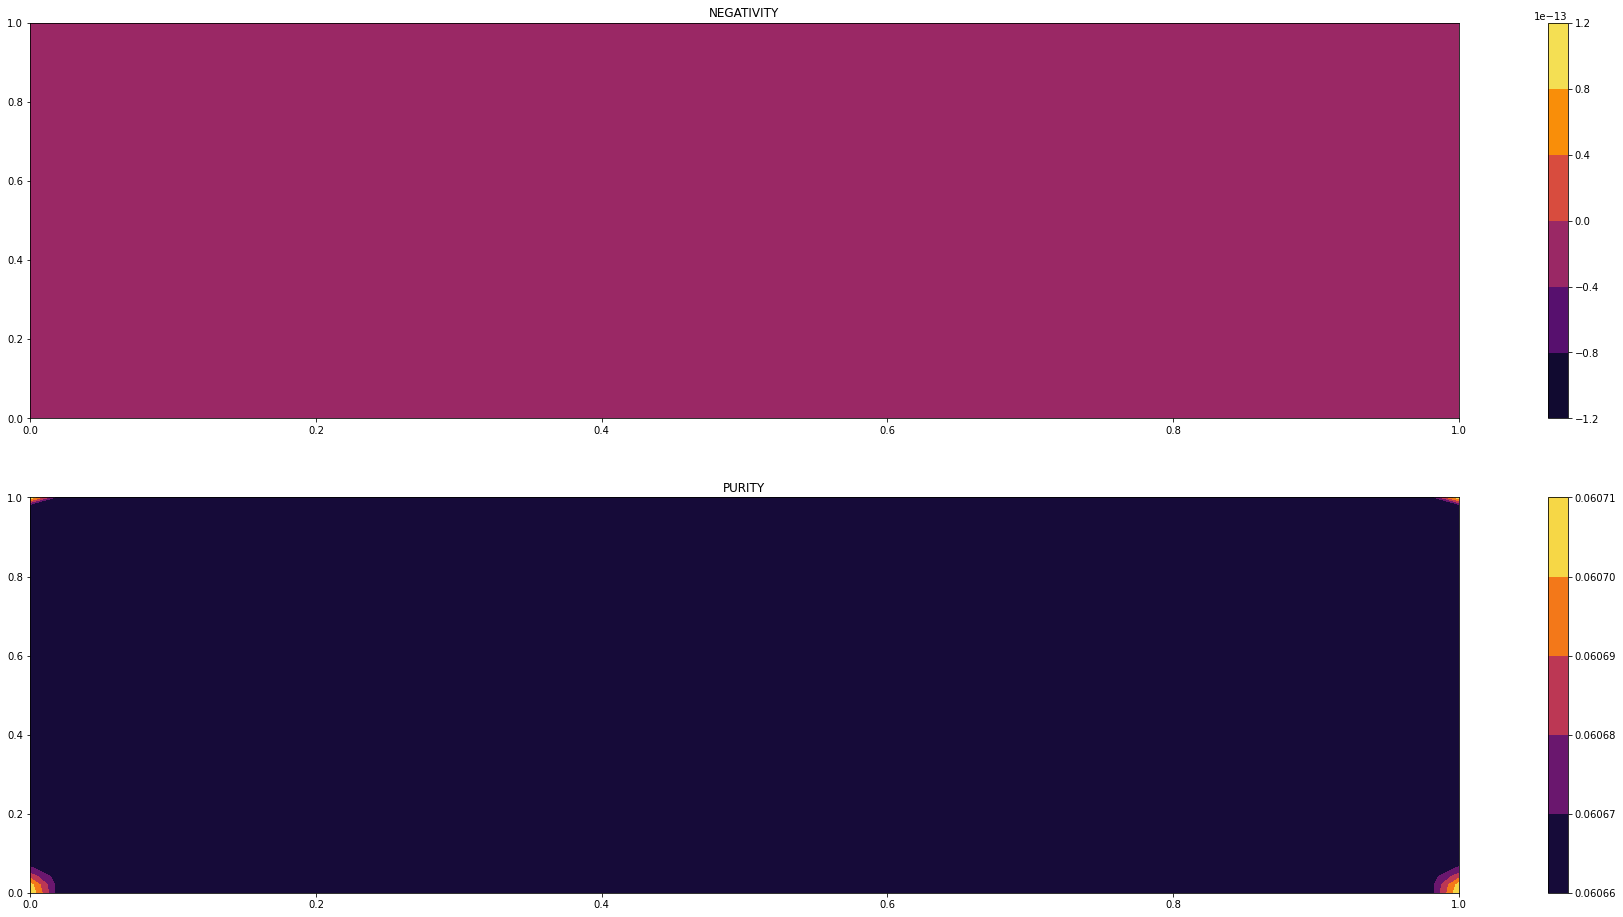

In [29]:
fig, (ax1,ax2) = plt.subplots(nrows = 2,figsize = (32,16))
cmap = plt.get_cmap('inferno')

neg = negativity_arr
pur = purity_arr

levels_neg = MaxNLocator(nbins=5).tick_values(neg.min(), neg.max())
norm_neg = BoundaryNorm(levels_neg, ncolors=cmap.N, clip=True)

levels_pur = MaxNLocator(nbins=5).tick_values(pur.min(), pur.max())
norm_pur = BoundaryNorm(levels_pur, ncolors=cmap.N, clip=True)


cf_neg = ax1.contourf(b,
                  c, neg, levels=levels_neg,cmap=cmap)
fig.colorbar(cf_neg, ax=ax1)
ax1.set_title('NEGATIVITY')


cf_pur = ax2.contourf(b,
                  c, pur, levels=levels_pur,cmap=cmap)
fig.colorbar(cf_pur, ax=ax2)
ax2.set_title('PURITY')
plt.show()


In [132]:
def ptrace(mtx, hold):
    """Performs partial trace of state with only one site #hold remains"""
    indexes = list(range(2*n_qubits_total))
    axis_order = [indexes.pop(hold), indexes.pop(hold + n_qubits_total - 1)]
    axis_order = indexes + axis_order
    mtx = np.transpose(np.reshape(mtx, [2]*2*n_qubits_total), axis_order)
    return np.trace(np.reshape(mtx, (2**(n_qubits_total-1), 2**(n_qubits_total-1), 2, 2)))

n_qubitsA = 2
n_qubitsB = 2
n_qubits_total = n_qubitsA + n_qubitsB

P0 = qt.basis(2,0) 
P1 = qt.basis(2,1)

HP0 = (qt.basis(2,0) + qt.basis(2,1))/np.sqrt(2)
HP1 = (qt.basis(2,0) - qt.basis(2,1))/np.sqrt(2)

q0 = HP0 * HP0.dag()
q0 = q0.full()
q1 = HP1 * HP1.dag()
q1 = q1.full()

psi00 = qt.tensor(P0,P0)
psi01 = qt.tensor(P0,P1)
psi10 = qt.tensor(P1,P0)
psi11 = qt.tensor(P1,P1)

P00 = psi00 * psi00.dag()
P01 = psi01 * psi01.dag()
P10 = psi10 * psi10.dag()
P11 = psi11 * psi11.dag()

ra = qt.rand_dm(2**n_qubitsA)
rb = qt.rand_dm(2**n_qubitsB)

rho_in  = qt.tensor(ra,rb)
rho_in = rho_in.full()

ra = ra.full()
rb = rb.full()

def qt_to_numpy_bridgeq(OP):
    OP = OP.full()
    OP_dag = np.kron(np.eye(2 ** (n_qubitsA - 1)), np.kron(OP.T.conj(), np.eye(2 ** (n_qubitsB - 1))))
    OP = np.kron(np.eye(2 ** (n_qubitsA - 1)), np.kron(OP, np.eye(2 ** (n_qubitsB - 1))))
    return OP, OP_dag

def two_par_measurement_anzats(b,c, separable, *args):
    if  separable == False:

        # CONSTRUCTING ENTANGLED MEAS. BASIS:
        phi00 = b * psi00 + np.sqrt(1 - b ** 2) * psi11
        phi11 = np.sqrt(1 - b ** 2) * psi00 - b * psi11
        phi01 = c * psi01 + np.sqrt(1 - c ** 2) * psi10
        phi10 = np.sqrt(1 - c ** 2) * psi01 - c * psi10

        OP00 = phi00 * phi00.dag()
        OP11 = phi11 * phi11.dag()
        OP10 = phi10 * phi10.dag()
        OP01 = phi01 * phi01.dag()

    else:
        if len(args) == 0:
            # CONSTRUCTING SEPARABLE MEAS. BASIS:
            psih0 = (qt.basis(2, 0) + qt.basis(2, 1)) / np.sqrt(2)
            psih1 = (qt.basis(2, 0) - qt.basis(2, 1)) / np.sqrt(2)
        else:
            psih0 = args[0] * (qt.basis(2, 0) + qt.basis(2, 1) / np.sqrt(2))
            psih1 = args[1] * (qt.basis(2, 0) - qt.basis(2, 1) / np.sqrt(2))

        phi00 = qt.tensor(psih0, psih0)
        phi11 = qt.tensor(psih1, psih1)
        phi01 = qt.tensor(psih0, psih1)
        phi10 = qt.tensor(psih1, psih0)

        OP00 = phi00 * phi00.dag()
        OP11 = phi11 * phi11.dag()
        OP10 = phi10 * phi10.dag()
        OP01 = phi01 * phi01.dag()

    R00,R00_dag = qt_to_numpy_bridgeq(OP00)
    R11, R11_dag = qt_to_numpy_bridgeq(OP11)
    R01,R01_dag = qt_to_numpy_bridgeq(OP01)
    R10, R10_dag = qt_to_numpy_bridgeq(OP10)

    return [R00, R00_dag, R11, R11_dag, R01, R01_dag, R10, R10_dag]

R00, R00_dag, R11, R11_dag, R01, R01_dag, R10, R10_dag = two_par_measurement_anzats(0.3,0.2, True)


In [133]:
R00_dag @ R00 + R01_dag @ R01 + R10_dag @ R10 + R11_dag @ R11

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In [134]:
rho_out = R00 @ rho_in @ R00_dag + R01 @ rho_in @ R01_dag + R10 @ rho_in @ R10_dag +  R11 @ rho_in @ R11_dag 

In [135]:
qt.Qobj(rho_out)

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.25      +0.00000000e+00j  0.        +0.00000000e+00j
  -0.16416819-1.27088493e-18j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.25      +0.00000000e+00j
   0.        +0.00000000e+00j -0.16416819-1.27088493e-18j]
 [-0.16416819-1.27088493e-18j  0.        +0.00000000e+00j
   0.25      +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j -0.16416819-1.27088493e-18j
   0.        +0.00000000e+00j  0.25      +0.00000000e+00j]]

In [136]:
q_ra = ptrace(rho_out,0)
q_ra

array([[ 0.5       +0.00000000e+00j, -0.32833638-2.54176986e-18j],
       [-0.32833638-2.54176986e-18j,  0.5       +0.00000000e+00j]])

In [137]:
q_rb = ptrace(rho_out,1)
q_rb

array([[0.5+0.j, 0. +0.j],
       [0. +0.j, 0.5+0.j]])

In [138]:
ra_out = q0 @ ra @ q0 + q1 @ ra @ q1
ra_out

array([[ 0.5       +0.00000000e+00j, -0.32833638+1.88832317e-18j],
       [-0.32833638+1.88832317e-18j,  0.5       +0.00000000e+00j]])

In [139]:
rb_out = q0 @ rb @ q0 + q1 @ rb @ q1
rb_out

array([[0.5+0.j, 0. +0.j],
       [0. +0.j, 0.5+0.j]])